<a href="https://colab.research.google.com/github/robinsonlakranew/Machine-Learning-Practice/blob/main/Sentiment_analysis_with_Movie_review_dateset(neural_network).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [57]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [58]:
train_dir = os.path.join(dataset_dir, 'train')
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [59]:
batch_size = 32
seed = 42

raw_train_df = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = 32,
    validation_split = 0.2,
    seed = seed,
    subset = 'training'
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [60]:
for text_batch, label_batch in raw_train_df.take(1):
  for i in text_batch:
    print(text_batch)
    break

tf.Tensor(
[b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
 b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into complicat

In [61]:
raw_val_df = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = 32,
    validation_split = 0.2,
    seed = seed,
    subset = 'validation'
)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [62]:
def custom_standardization(input_data):
  cap = tf.strings.lower(input_data)
  ff = tf.strings.regex_replace(cap, '<br />', ' ')
  return tf.strings.regex_replace(ff, '[%s]' % re.escape(string.punctuation),
                                  '')

vectorize_layer = layers.TextVectorization(standardize=custom_standardization,
                                           max_tokens=1000,
                                           output_mode='int',
                                           output_sequence_length=250)

train_text = raw_train_df.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [63]:
# retrieve a batch (of 32 reviews and labels) from the dataset
# text_batch, label_batch = next(iter(raw_train_df))
for text_batch, label_batch in raw_train_df.take(1):
  first_review, first_label = text_batch[0], label_batch[0]
  break

In [64]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label


print("Review", first_review)
print("Label", raw_train_df.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[ 86,  17, 260,   2, 222,   1, 571,  31, 229,  11,   1,   1,  51,
         22,  25, 404, 251,  12, 306, 282,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,

In [65]:
raw_train_ds = raw_train_df
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_df.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [66]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [67]:
model = tf.keras.models.Sequential([
                                    layers.Embedding(1000+1, 16),
                                    layers.Dropout(0.2),
                                    layers.GlobalAveragePooling1D(),
                                    layers.Dropout(0.2),
                                    layers.Dense(1)
])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          16016     
                                                                 
 dropout_2 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 16,033
Trainable params: 16,033
Non-trainable params: 0
__________________________________________________

In [68]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0))

In [69]:
history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)

Epoch 1/10
625/625 [==============================] - 11s 17ms/step - loss: 0.6717 - binary_accuracy: 0.6535 - val_loss: 0.6344 - val_binary_accuracy: 0.7260
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5839 - binary_accuracy: 0.7584 - val_loss: 0.5408 - val_binary_accuracy: 0.7836
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5003 - binary_accuracy: 0.8009 - val_loss: 0.4723 - val_binary_accuracy: 0.8096
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.4449 - binary_accuracy: 0.8238 - val_loss: 0.4309 - val_binary_accuracy: 0.8224
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.4116 - binary_accuracy: 0.8335 - val_loss: 0.4062 - val_binary_accuracy: 0.8332
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3902 - binary_accuracy: 0.8407 - val_loss: 0.3905 - val_binary_accuracy: 0.8388
Epoch 7/10
625/625 [==============================] - 3s 5ms/s

In [70]:
loss, accuracy = model.evaluate(test_ds)
print(loss, accuracy)

782/782 [==============================] - 8s 10ms/step - loss: 0.3594 - binary_accuracy: 0.8465
0.35942399501800537 0.8464800119400024


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


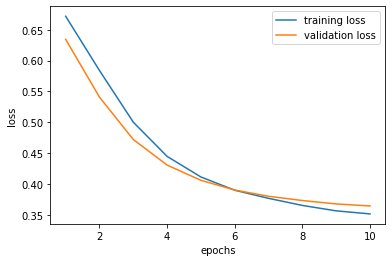

In [71]:
hist = history.history
print(hist.keys())

plt.plot(range(1,11), hist['loss'], label='training loss')
plt.plot(range(1,11), hist['val_loss'], label='validation loss')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

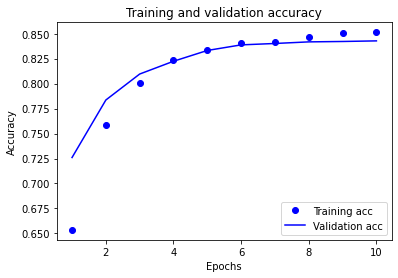

In [72]:
epochs=range(1,11)
plt.plot(epochs, hist['binary_accuracy'], 'bo', label='Training acc')
plt.plot(epochs, hist['val_binary_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()